# Construct different Hamiltonians and their Quantum Boltzmann Machines

In this brief notebook we will have a look at different Hamiltonians and their corresponding Gibbs states, aka Quantum Boltzmann Machines.

## Setup

We will use the [`quimb`](https://quimb.readthedocs.io) library to describe the states, density matrices, and Hamiltonians.
`quimb` provides some pre-defined hamiltonians for common many-body quantum systems in 1D and 2D, like the ones used in the [VQE-generated quantum circuit dataset](http://arxiv.org/abs/2302.09751) paper by Nakayama et al.

In [1]:
import quimb as qu
import matplotlib.pyplot as plt
import numpy as np

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
rng = np.random.default_rng(seed=1)

## Transverse-field ising model in 1D

### Hamiltonian

The Hamiltonian of the TFIM in 1D is constructed by starting from a _chain_ of sites connected via nearest-neighbors interactions of the spin `Z` operator, plus a term on each site corresponding to the _transverse field_ represented by the spin `X` operator

$$
H=J_{z} \sum_{\langle i, j\rangle}  Z_i Z_j  - B_x \sum_j X_j
$$

In [3]:
# define number of sites == number of qubits (each site is a 2-level system)
n = 6

**Note** here that there are only 2 parameters in the Hamiltonian because we define the interactions and field in an isotropic way (they are the same no matter what sites we consider along the chain)

In [4]:
# define the hamiltonian given the interaction parameters
jz = rng.normal()
bx = rng.normal()
print(f"Spin interaction: {jz:.3f}")
print(f"Field value: {bx:.3f}")

Spin interaction: 0.346
Field value: 0.822


In [5]:
tfim = qu.ham_ising(n, jz, bx)

By looking at the Hamiltonian in matrix form we can see that there are off-diagonal terms due to the spin `X` operator:

In [6]:
tfim

[[ 0.43198  -0.410809 -0.410809 ...  0.        0.        0.      ]
 [-0.410809  0.259188  0.       ...  0.        0.        0.      ]
 [-0.410809  0.        0.086396 ...  0.        0.        0.      ]
 ...
 [ 0.        0.        0.       ...  0.086396  0.       -0.410809]
 [ 0.        0.        0.       ...  0.        0.259188 -0.410809]
 [ 0.        0.        0.       ... -0.410809 -0.410809  0.43198 ]]

In [7]:
tfim.shape

(64, 64)

The dimension of the Hilbert space is $2^n$

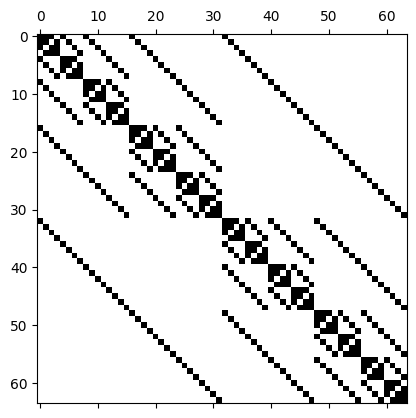

In [8]:
# in a spy plot, the non-zero entries of the matrix are black
# we can here check that the dimension of the matrix is 2^n x 2^n = 64 x 64
_ = plt.spy(tfim)

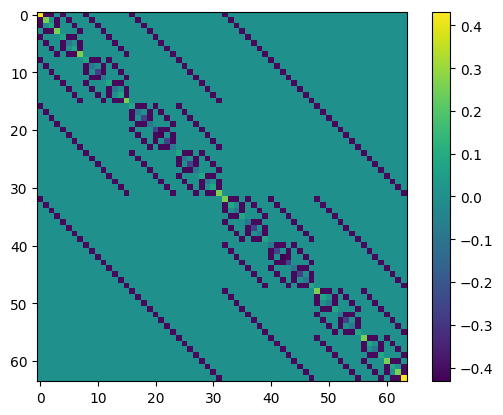

In [9]:
# a heatmap will show the different intensities on a color scale
_ = plt.imshow(tfim, interpolation='nearest')
_ = plt.colorbar()

### Gibbs state

A Quantum Boltzmann Machine is defined as the Gibbs state of a particular parameterized Hamiltonian $\mathcal{H}_\theta$ at temperature $T=1/\beta$:

$$
\rho_\theta(\beta) = \frac{e^{-\beta \mathcal{H}_\theta}}{Z} \, ,
$$

where $Z$ is the partition function $Z= \mathrm{Tr}[e^{-\beta \mathcal{H}_\theta}]$

In [10]:
# define beta=1 (since all the parameters in the hamiltonian can simply be rescaled by this number, this makes it easy)
beta = 1.0

If the Hamiltonian can be exactly diagonalized (it is not too big) then it is easy to define its exponential and the partition function.

**Note** here that the partition function involves a sum over all possible states and it becomes intractable for large systems. One would need to use approximate methods to compute the trace.

In [11]:
# do exact diagonalization (can be done on laptop up to n~16)
el, ev = qu.eigh(tfim)

In [12]:
# the numerator: using eigenvalues el and eigenvectors ev
exp_bh = ev @ np.diag(np.exp(-beta * el)) @ ev.H

In [13]:
exp_bh

[[1.114001 0.46872  0.507863 ... 0.013495 0.013118 0.004962]
 [0.46872  1.300063 0.202771 ... 0.037442 0.005248 0.013118]
 [0.507863 0.202771 1.518147 ... 0.005552 0.037442 0.013495]
 ...
 [0.013495 0.037442 0.005552 ... 1.518147 0.202771 0.507863]
 [0.013118 0.005248 0.037442 ... 0.202771 1.300063 0.46872 ]
 [0.004962 0.013118 0.013495 ... 0.507863 0.46872  1.114001]]

In [14]:
# the denominator: the partition function as the trace over the numerator
z = qu.trace(exp_bh)

In [15]:
print(f"Partition function: {z}")

Partition function: 106.51485532025242


The Gibbs state for the TFIM Hamiltonian is then:

In [16]:
rho_tfim = exp_bh/z

In [17]:
rho_tfim

[[1.045864e-02 4.400517e-03 4.768006e-03 ... 1.266982e-04 1.231529e-04 4.658556e-05]
 [4.400517e-03 1.220546e-02 1.903689e-03 ... 3.515210e-04 4.926778e-05 1.231529e-04]
 [4.768006e-03 1.903689e-03 1.425292e-02 ... 5.212123e-05 3.515210e-04 1.266982e-04]
 ...
 [1.266982e-04 3.515210e-04 5.212123e-05 ... 1.425292e-02 1.903689e-03 4.768006e-03]
 [1.231529e-04 4.926778e-05 3.515210e-04 ... 1.903689e-03 1.220546e-02 4.400517e-03]
 [4.658556e-05 1.231529e-04 1.266982e-04 ... 4.768006e-03 4.400517e-03 1.045864e-02]]

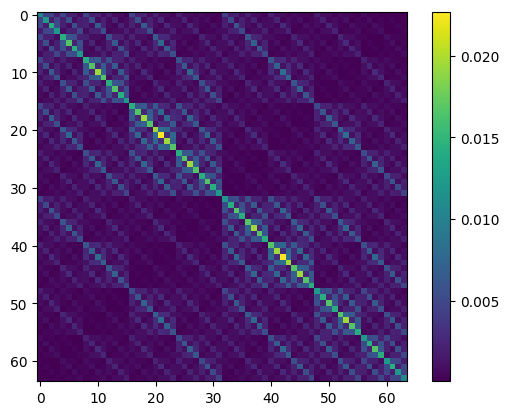

In [18]:
_ = plt.imshow(rho_tfim, interpolation='nearest')
_ = plt.colorbar()

#### Speed up

`quimb` has a convenient function for creating Gibbs (thermal) states of a given Hamiltonian. Under the hood it does what we just did above, but with improvements on speed when the number of qubits increases.

In [19]:
rho_tfim_qb = qu.thermal_state(tfim, beta, precomp_func=False)  # if precomp_func=True, it returns a fuction of beta.

In [20]:
rho_tfim_qb

[[1.045864e-02 4.400517e-03 4.768006e-03 ... 1.266982e-04 1.231529e-04 4.658556e-05]
 [4.400517e-03 1.220546e-02 1.903689e-03 ... 3.515210e-04 4.926778e-05 1.231529e-04]
 [4.768006e-03 1.903689e-03 1.425292e-02 ... 5.212123e-05 3.515210e-04 1.266982e-04]
 ...
 [1.266982e-04 3.515210e-04 5.212123e-05 ... 1.425292e-02 1.903689e-03 4.768006e-03]
 [1.231529e-04 4.926778e-05 3.515210e-04 ... 1.903689e-03 1.220546e-02 4.400517e-03]
 [4.658556e-05 1.231529e-04 1.266982e-04 ... 4.768006e-03 4.400517e-03 1.045864e-02]]

In [21]:
np.allclose(rho_tfim, rho_tfim_qb)

True

### Expectation values

One of the most common operations during the training of QBMs is the calculation of expectation values of operators with respect to the Gibbs state or a target state. `quimb` makes it easy to compute expectation values.

In [22]:
# expectation value of the spin Z operator w.r.t the Gibbs state: spin operators are Pauli/2
op = qu.spin_operator('z')
op

[[ 0.5+0.j  0. +0.j]
 [ 0. +0.j -0.5+0.j]]

In [23]:
# e.g. with Pauli Z
opp = qu.pauli('Z')
opp

[[ 1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j]]

Now we need to lift this 1-qubit operator to the full Hilbert space of our Hamiltonian (and Gibbs state). Remember we are working in a $\mathrm{dim} = 2^n$ space

In [24]:
# dimension of our system: quimb wants to keep each 2-level subsystem dimension in a list
dims = (2,) * n

In [25]:
# spin `Z` on "site" 3
op3 = qu.ikron(op, dims, inds=[3])
assert op3.shape[0] == tfim.shape[0]

In [26]:
# expectation value
exp_val = qu.expec(rho_tfim_qb, op3)
exp_val

1.6479873021779667e-17

In [27]:
# expectation value of the full hamiltonian: aka the Energy of the state
exp_val = qu.expec(rho_tfim_qb, tfim)
exp_val

-0.9892285757063022

## Heisenberg model in 2D

### Hamiltonian

In `quimb` we have access to several pre-defined models in 1D and 2D. We can also easily create our own models. Here we want to demonstrate this with the Heisenberg model in 2 dimensions, following the first part of [this example](https://quimb.readthedocs.io/en/latest/examples/ex_2d.html) notebook.

The Hamiltonian we create is defined from spin operators on sites of a square lattice of dimensions $n \times m$:

$$
H = \sum_{\langle i, j \rangle}\left(J_x X_i X_j + J_y Y_i Y_j + J_z Z_i Z_j \right) + \sum_i B_z Z_i 
$$

We define a function to create this Hamiltonian in matrix form using `quimb`'s functionalities (in the simples case where $J_x=J_y=J_z=J$)

In [28]:
import itertools

def ham_heis_2D(n, m, j=1.0, bz=0.0, cyclic=False, sparse=True):
    
    dims = [[2] * m] * n  # shape (n, m)
    
    # generate tuple of all site coordinates
    sites = tuple(itertools.product(range(n), range(m)))
    
    # generate neighbouring pairs of coordinates
    def gen_pairs():
        for i, j, in sites:
            above, right = (i + 1) % n, (j + 1) % m
            # ignore wraparound coordinates if not cyclic
            if cyclic or above != 0:
                yield ((i, j), (above, j))
            if cyclic or right != 0:
                yield ((i, j), (i, right))
    
    # generate all pairs of coordinates and directions
    pairs_ss = tuple(itertools.product(gen_pairs(), 'xyz'))
    
    # make XX, YY and ZZ interaction from pair_s
    #     e.g. arg ([(3, 4), (3, 5)], 'z')
    def interactions(pair_s):
        pair, s = pair_s
        Sxyz = qu.spin_operator(s, sparse=True)
        return qu.ikron([j * Sxyz, Sxyz], dims, inds=pair)
        
    # function to make Z field at ``site``
    def fields(site):
        Sz = qu.spin_operator('z', sparse=True)
        return qu.ikron(bz * Sz, dims, inds=[site])
                
    # combine all terms
    all_terms = itertools.chain(map(interactions, pairs_ss), 
                                map(fields, sites) if bz != 0.0 else ())
    H = sum(all_terms)

    # can improve speed of e.g. eigensolving if known to be real
    if qu.isreal(H):
        H = H.real
    
    if not sparse:
        H = qu.qarray(H.A)
        
    return H

Now let's define a 2D lattice of $n$ rows and $m$ columns:

In [29]:
n, m = 4, 3  # this is a total of 12 qubits!!
dims = [[2] * m] * n

for row in dims:
    print(row)

[2, 2, 2]
[2, 2, 2]
[2, 2, 2]
[2, 2, 2]


And the Hamiltonian parameters:

In [30]:
# define the hamiltonian given the interaction parameters
j = rng.normal()
bz = rng.normal()
print(f"Spin interaction: {j:.3f}")
print(f"Field value: {bz:.3f}")

Spin interaction: 0.330
Field value: -1.303


In [31]:
heis2d = ham_heis_2D(n, m, j, bz, cyclic=False, sparse=False)

**Note** it takes time to create this object because the dimension of the Hilbert space is really large: the total Hilbert space is the tensor product of $n \cdot m$ 2-level systems!

In [32]:
heis2d.shape

(4096, 4096)

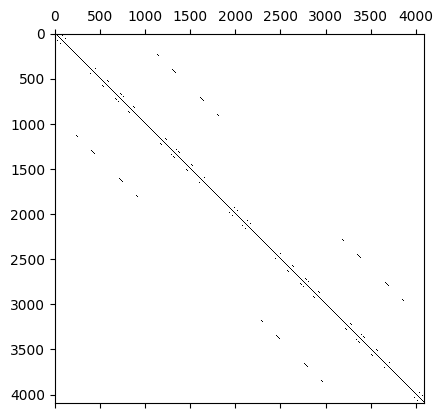

In [33]:
_ = plt.spy(heis2d)

This Hamiltonian is very sparse in such a large Hilbert space!

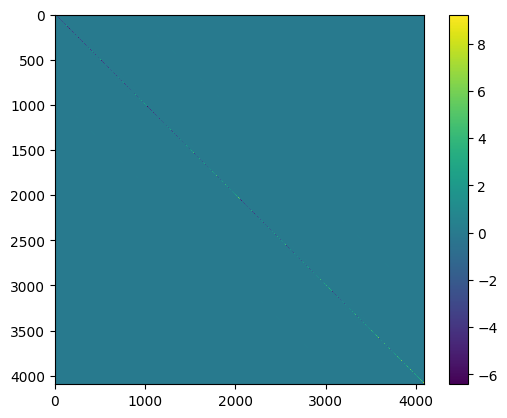

In [34]:
_ = plt.imshow(heis2d, interpolation='nearest')
_ = plt.colorbar()

In [47]:
# we can quickly compute the smallest and largest energies for this system: make it sparse and the time goes down by 32x
minE, maxE = qu.bound_spectrum(qu.sparse(heis2d))
print(f"Smallest energy: {minE}\nLargest energy: {maxE}")

Smallest energy: -6.41458581584677
Largest energy: 9.223300963405572


### Gibbs state

Define the Gibbs state for this new Hamiltonian using `quimb` built-in function

In [49]:
# let's test different temperatures (1/beta)
rho_heis2d_beta = qu.thermal_state(heis2d, beta, precomp_func=True)  # this returns a function now

Try different $\beta$ values, i.e. these are thermal states at different temperatures. Since the computationally expensive exact diagonalization has been done already and precomputed, changing the temperature is very fast

In [36]:
beta = 1.0
rho_heis2d_1 = rho_heis2d_beta(beta)

In [37]:
beta = 2.0
rho_heis2d_2 = rho_heis2d_beta(beta)

In [38]:
# low temperature...
beta = 100.0
rho_heis2d_100 = rho_heis2d_beta(beta)

### Ground state

In [39]:
ge, gs = qu.eigh(heis2d, k=1)  # only the lowest eigenvalue and eigenvector

The ground state is represented as a `ket` (a column vector)

In [40]:
gs.shape

(4096, 1)

In [41]:
print(f"The ground state energy is: {ge[0]:.3f}")

The ground state energy is: -6.415


### Expectation values

The ground state has a similar energy to a very low temperature state. This is because cooling down the system will make it settle on its ground state!

In [42]:
print(f"Energy expectation value on ground state: {qu.expec(heis2d, gs):.3f}")

Energy expectation value on ground state: -6.415


In [43]:
print(f"Energy expectation value on thermal state (low temperature!): {qu.expec(heis2d, rho_heis2d_100):.3f}")

Energy expectation value on thermal state (low temperature!): -6.415


Thermal states at higher temperatures have higher energies...

In [44]:
print(f"Energy expectation value on thermal state (high temperature!): {qu.expec(heis2d, rho_heis2d_1):.3f}")

Energy expectation value on thermal state (high temperature!): -3.695
